In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy
import scipy.constants as co
import scipy.stats as ss
from scipy.ndimage import shift
import itertools
import pickle
from pathlib import Path

from lmfit.models import GaussianModel, LinearModel

In [2]:
import pickle
#how to read
#fileObj = open('data/r76-80V-naitrig-100eV-goodchi.pkl', 'rb')
fileObj = open('data/r76_events_coincidencepeak_LE.pkl', 'rb')
exampleObj = pickle.load(fileObj)
fileObj.close()
print(exampleObj)

                                                                    Z1  \
                                                                    QI   
72209162200 20309    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            40339    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            50269    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            60108    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            60849    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
...                                                                ...   
72209172155 2020326  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2020591  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2030429  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2060050  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2060679  [65532, 65532, 65532, 65532, 65532, 65532, 655...   

                                     

In [3]:
import statistics as st
def isRailed(v):
    if(np.isnan(v).any()):
        return True
    if(st.mode(v)==0):
        return True
    return False

In [4]:
#'../coin_analysis/data/r76-coinpeak-lt-50keV.txt'
import pulseAnalysis as pa

pulse_struct = pa.parseEventList('../coin_analysis/data/r76-coinpeak-lt-50keV.txt')

series_numbers = []
event_numbers = []

for series, events in pulse_struct.items():
    for event in events:
        # Convert series to string, remove underscore, and convert to integer
        series_number = int(str(series).replace('_', ''))
        
        # Append series number and event number to their respective lists
        series_numbers.append(series_number)
        event_numbers.append(event)
        
#print("AAAAAAAAAAAAAAAAAAAAAAAAAA",series_numbers)
#pulse_struct = sps.parseEventList('../coin_analysis/data/r76_events_coincidencepeak.txt')

   SeriesNumber  EventNumber
0   72209162200        20309
1   72209162200        40339
2   72209162200        50269
3   72209162200        60108
4   72209162200        60849
5   72209162200        80307
6   72209162200       100246
7   72209162200       110588
8   72209162200       110617
9   72209162200       120647
[72209162200 72209171225 72209172155]
[  20309   40339   50269   60108   60849   80307  100246  110588  110617
  120647  120688  130460  140628  150823  160296  170423  180002  180423
  230432  240270  270221  340151  340912  380054  380186  390511  420391
  420816  430710  440168  480387  480389  500725  520930  540170  540903
  550322  560707  560931  570415  580008  580723  590121  610172  610663
  610684  640653  650751  670228  670650  690338  710437  740337  750334
  750490  760179  770287  780145  780259  780278  780628  800530  810923
  820568  840012  840222  850265  860663  880573  880913  910282  920809
  920948  930239  930872  940631  950888  960920  970767 10

In [5]:
import copy

coindata = pd.read_csv("../coin_analysis/data/r76_events_coincidencepeak.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','PTOFdelay','pt_keVee'], \
            delim_whitespace=False)

series_nums = np.asarray(coindata['SeriesNumber'])
event_nums = np.asarray(coindata['EventNumber'])
EkeV = np.asarray(coindata['pt_keVee'])
PTOFdelay = np.asarray(coindata['PTOFdelay'])
sers=copy.deepcopy(series_nums)
evs=copy.deepcopy(event_nums)

newPTOF=[]
newE=[]
newEv=[]
newSer=[]
tacohut=evs*10000+sers
pizzabell = []
for event, series in zip(event_numbers, series_numbers):
    pizzabell.append(event*10000 + series)

for i,s in enumerate(tacohut):
    if(tacohut[i] in pizzabell):
        newPTOF.append(PTOFdelay[i])
        newE.append(EkeV[i])
        newEv.append(evs[i])
        newSer.append(sers[i])
        
print(len(newPTOF))


def getEnergy(series,ev):
    energy = 0

    for i in range(0, len(series_nums)):
        if series_nums[i] == series:
            if event_nums[i] == ev:
                energy = (EkeV[i])
    return energy

def getBaseline(ptpulse):
    
    x = np.linspace(100, 250, 150)
    #print(len(x))
    y = ptpulse[100:250]
    #print(len(y))
    
    #print(x)
    #print(y)
    
    baseline_model = np.polyfit(x, y, 1)
    baseline_model_fn = np.poly1d(baseline_model)
    
    return(baseline_model_fn)

1156


In [6]:
# ax1.fill_between(np.arange(0, best_cross + 1), bshifted_pT[:best_cross + 1], 0, color='gray', alpha=0.5)
                
              #      area = np.trapz(bshifted_pT[:best_cross + 1], dx=1)
                #    print("Area:", area)
def getPTPulse(pulses,series=72209162200,ev=20309,chan=[('Z1','PA'),('Z1','PB'),('Z1','PD'),('Z3','PA'),('Z3','PB'),('Z3','PD')]):
    ptpulse=[]
    ccount=0
    for c in chan:
        #print(c[0])
        pulse = pulses[c[0]][c[1]][series,ev]
        if(isRailed(pulse)):
            continue
        mean = np.mean(pulse[100:])
        #print(mean)
        pulse = pulse-mean
        #print(pulse)
        #print(np.size(ptpulse))
        if(ccount==0):
            ptpulse=pulse
        else:
            ptpulse+=pulse
        ccount+=1
        
        
    return ptpulse

def getPABDPulse(pulses, series=72209162200, ev=20309, chan=[('Z1', 'PA'), ('Z1', 'PB'), ('Z1', 'PD'), ('Z3', 'PA'), ('Z3', 'PB'), ('Z3', 'PD')]):
    papulse = []
    pbpulse = []
    pcpulse = []
    pdpulse = []
    pepulse = []
    pfpulse = []

    for c in chan:
        pulse = pulses[c[0]][c[1]][series, ev]
        if isRailed(pulse):
            continue
        mean = np.mean(pulse[100:])
        pulse = pulse - mean
        #z1pa=pc z1pb=pf z1pd=pe z3pa=pb z3pb=pa z3pd=pd

        if c[0] == 'Z1':
            if c[1] == 'PA':
                if len(pcpulse) == 0:
                    pcpulse = pulse         
            elif c[1] == 'PB':
                if len(pfpulse) == 0:
                    pfpulse = pulse
            elif c[1] == 'PD':
                if len(pepulse) == 0:
                    pepulse = pulse
        elif c[0] == 'Z3':
            if c[1] == 'PA':
                if len(pbpulse) == 0:
                    pbpulse = pulse         
            elif c[1] == 'PB':
                if len(papulse) == 0:
                    papulse = pulse
            elif c[1] == 'PD':
                if len(pdpulse) == 0:
                    pdpulse = pulse
                

    return papulse, pbpulse, pcpulse, pdpulse, pepulse, pfpulse

def getPABDPulseCD(pulses,series=72209162200,ev=20309):
    
    pA,pB,pC,pD,pE,pF=getPABDPulse(pulses,series,ev)

    #adding discriminator
    D = 100

    end_valuesA=pA[3997:]
    end_valuesB=pB[3997:]
    end_valuesC=pC[3997:]
    end_valuesD=pD[3997:]
    end_valuesE=pE[3997:]
    end_valuesF=pF[3997:]

    CD_pulseA = shift(pA, D, cval=np.nan)
    CD_pulseB = shift(pB, D, cval=np.nan)
    CD_pulseC = shift(pC, D, cval=np.nan)
    CD_pulseD = shift(pD, D, cval=np.nan)
    CD_pulseE = shift(pE, D, cval=np.nan)
    CD_pulseF = shift(pF, D, cval=np.nan)


    #adding the cut off values to the front of the new pulse
    CD_pulseA[0:99] = end_valuesA
    CD_pulseB[0:99] = end_valuesB
    CD_pulseC[0:99] = end_valuesC
    CD_pulseD[0:99] = end_valuesD
    CD_pulseE[0:99] = end_valuesE
    CD_pulseF[0:99] = end_valuesF
    #print(new_pulse)
        
    return CD_pulseA, CD_pulseB, CD_pulseC, CD_pulseD, CD_pulseE, CD_pulseF


def getPTPulseCD(pulses,series=72209162200,ev=20309):
    
    pulse = getPTPulse(pulses, series, ev)

    #adding discriminator
    D = 100

    end_values = pulse[3997:]
    
    CD_pulse = shift(pulse, D, cval=np.nan)

    #adding the cut off values to the front of the new pulse
    CD_pulse[0:99] = end_values
    #print(new_pulse)
        
    return CD_pulse

def getPTPulseCFD(pulses,series=72209162200,ev=20309):
        
    pulse = getPTPulse(pulses, series, ev)
    
    #CFD formula
    F = 0.9
    D = 100

    end_values = pulse[3997:]
    #print(end_values)
    new_pulse = shift(pulse, D, cval=np.nan)
    #print(new_pulse)

    #adding the cut off values to the front of the new pulse
    new_pulse[0:99] = end_values
    #print(new_pulse)

    CFD_pulse = F*(pulse)-new_pulse
    
    return CFD_pulse
def getBadBL_PTOF(pulses, series, ev):
    pulse = getPTPulseCD(pulses, series, ev)
    asdf = np.linspace(150, 300)
    asdfg = pulse[np.round(asdf).astype(int)]  # Round and convert to int
    asdf1 = np.linspace(2500, 3000)
    asdfg1 = pulse[np.round(asdf1).astype(int)]  # Round and convert to int
    lowBinAvg = np.mean(asdfg)
    hiBinAvg = np.mean(asdfg1)
    if np.abs(hiBinAvg - lowBinAvg) > 500:
        return False
    else:
        return True
        
def getBadBL(obj, series=72209162200, ev=20309):
    pT = getPTPulseCD(obj,series,ev)+3000
    baseline = getBaseline(pT)
    xB = np.linspace(0, 4095, 4096)
    yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
    bshifted_pT = np.subtract(pT,yB)
    asdf = np.linspace(150, 300) 
    asdfg = bshifted_pT[np.round(asdf).astype(int)]  
    asdf1 = np.linspace(2500, 3000)
    asdfg1 = bshifted_pT[np.round(asdf1).astype(int)]  
    lowBinAvg = np.mean(asdfg)
    #print("lo avg", lowBinAvg)
    hiBinAvg = np.mean(asdfg1)
    #print("hi avg", hiBinAvg)
    if ((hiBinAvg - lowBinAvg) > 500) or ((hiBinAvg - lowBinAvg)<-170):#upsloping/downsloping bl should have different thrs
        return False
    else:
        return True

24
Series Number: 72209162200
Event Number: 3560843
Energy: 16.46908499042 keV


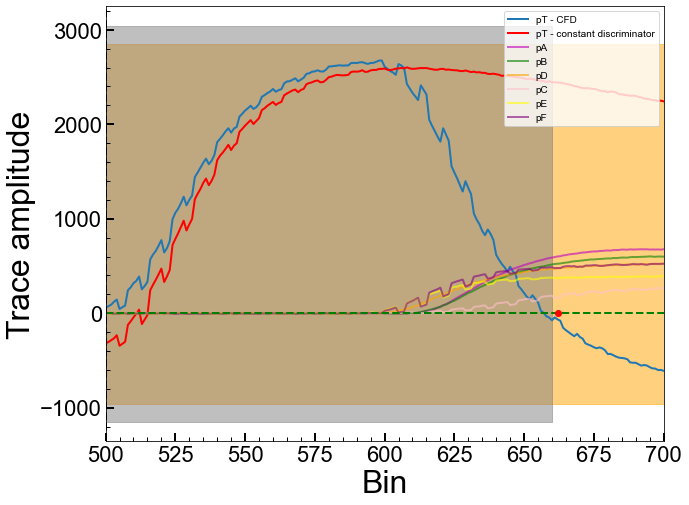

Series Number: 72209162200
Event Number: 3680615
Energy: 19.93241059032 keV


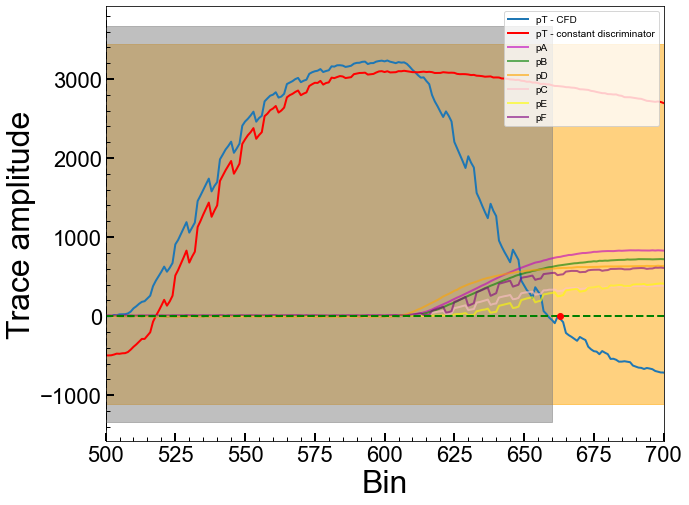

Series Number: 72209162200
Event Number: 4000494
Energy: 46.64699197751 keV


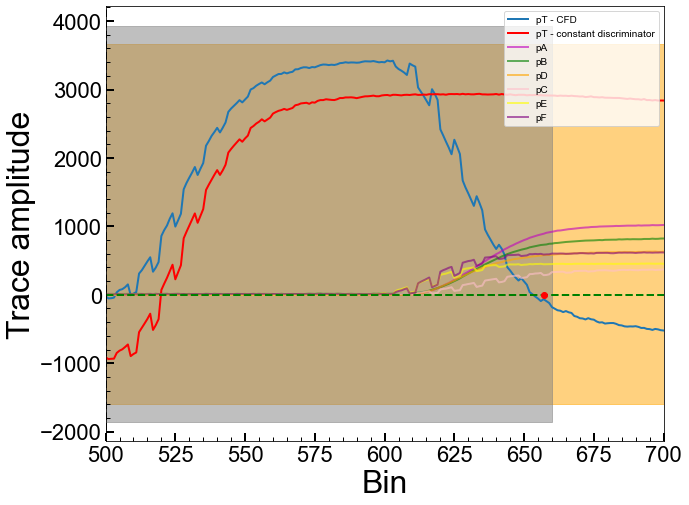

Series Number: 72209162200
Event Number: 4160243
Energy: 23.5702665941 keV


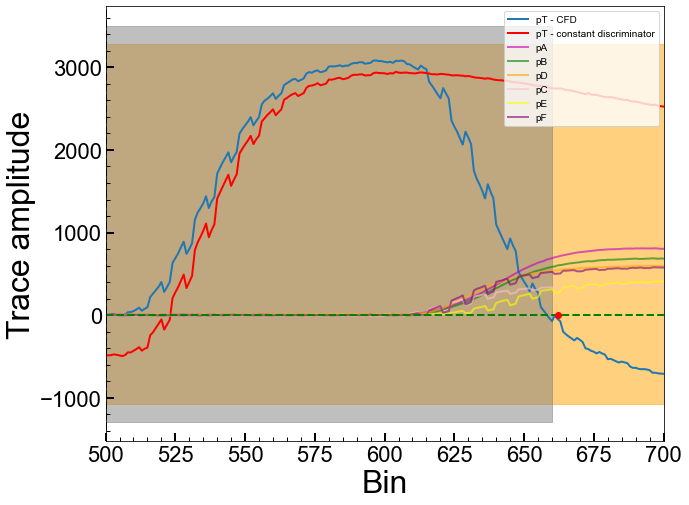

Series Number: 72209162200
Event Number: 4960169
Energy: 31.99086590787 keV


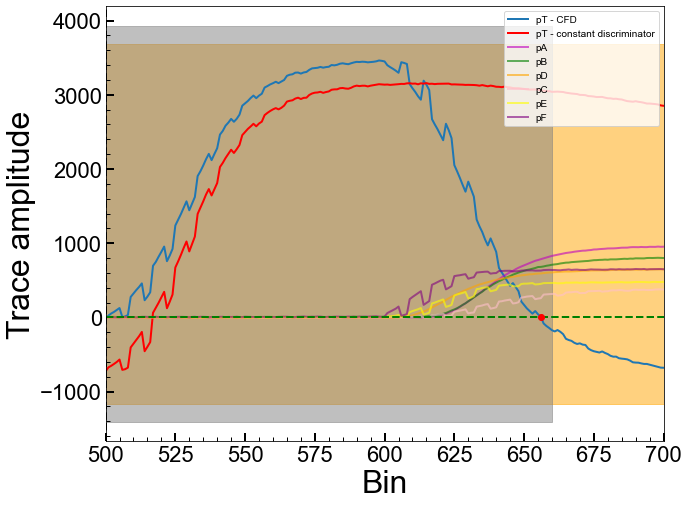

Series Number: 72209162200
Event Number: 5180413
Energy: 9.511136941897 keV


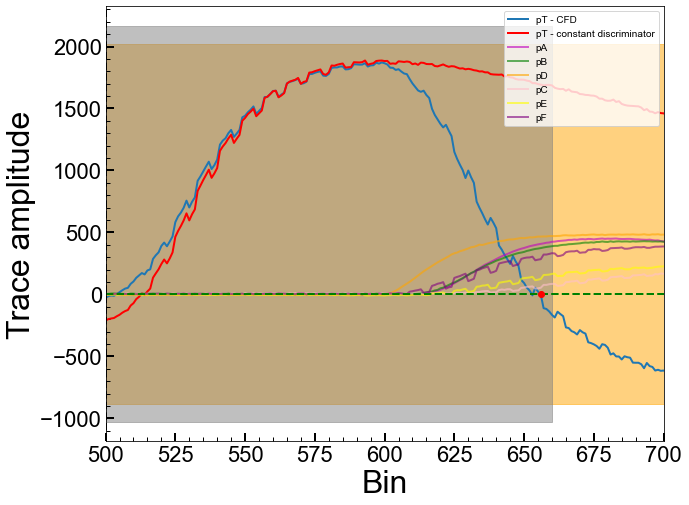

Series Number: 72209162200
Event Number: 5290181
Energy: 9.843291102842 keV


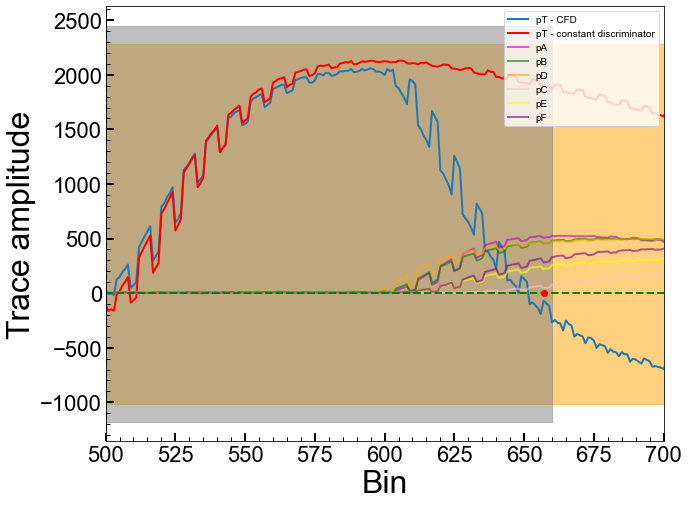

Series Number: 72209162200
Event Number: 5650437
Energy: 16.92945898266 keV


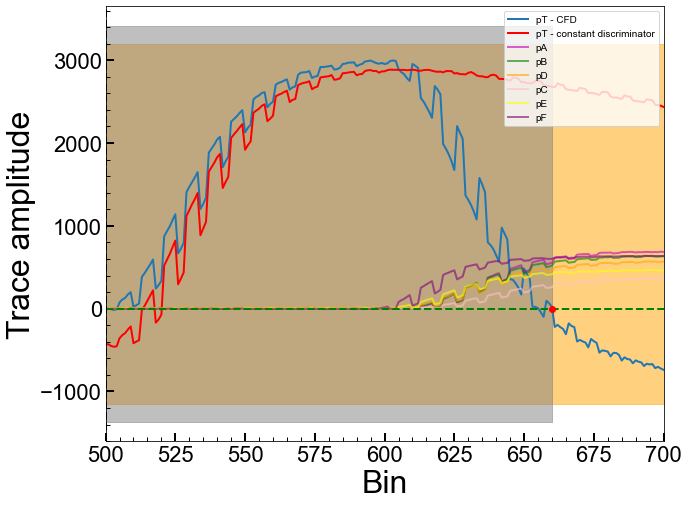

Series Number: 72209162200
Event Number: 5790661
Energy: 16.29966697281 keV


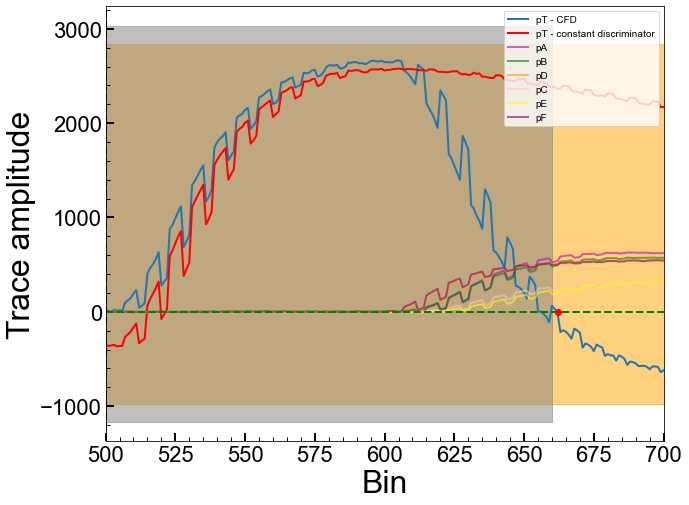

Series Number: 72209162200
Event Number: 5810300
Energy: 16.97145386573 keV


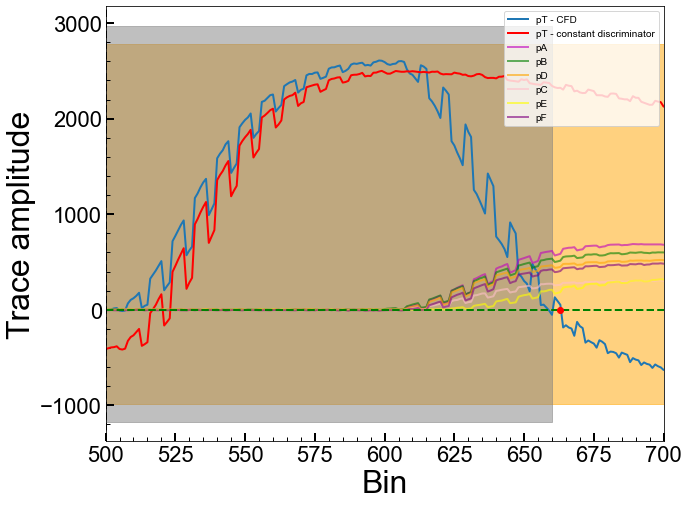

Series Number: 72209162200
Event Number: 5830100
Energy: 28.26943125583 keV


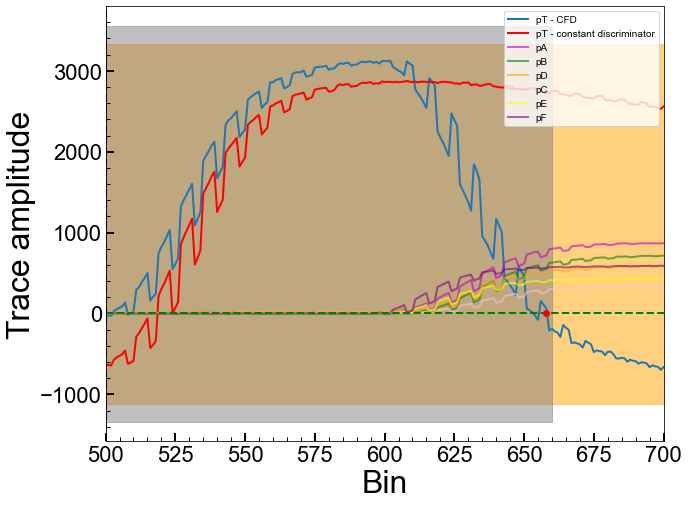

Series Number: 72209162200
Event Number: 5850078
Energy: 26.02048954514 keV


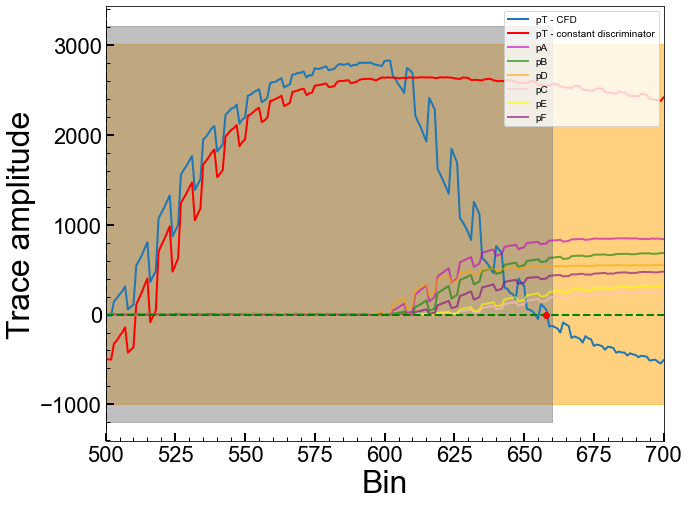

Series Number: 72209162200
Event Number: 5960312
Energy: 44.23948614675 keV


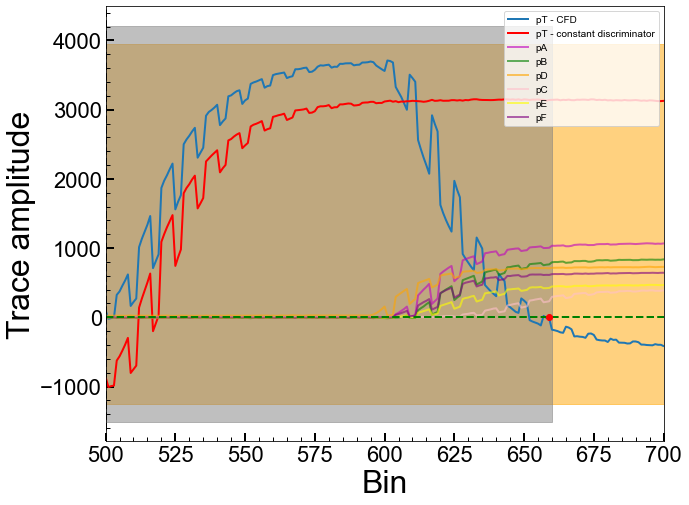

Series Number: 72209162200
Event Number: 6100761
Energy: 7.846144264861 keV


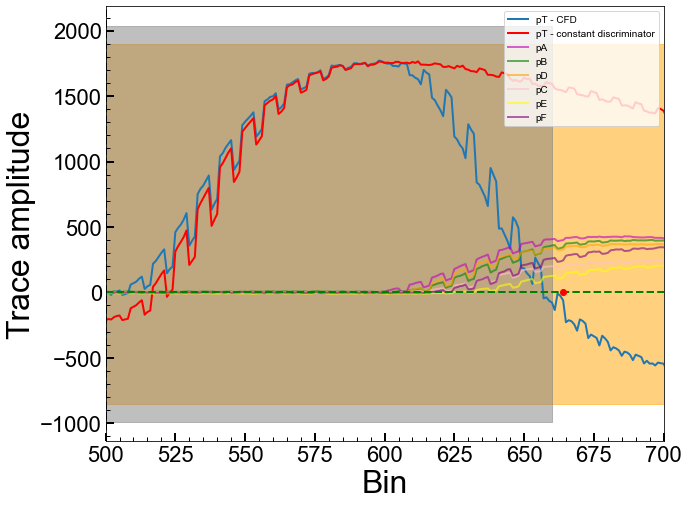

Series Number: 72209162200
Event Number: 6300112
Energy: 19.05171184489 keV


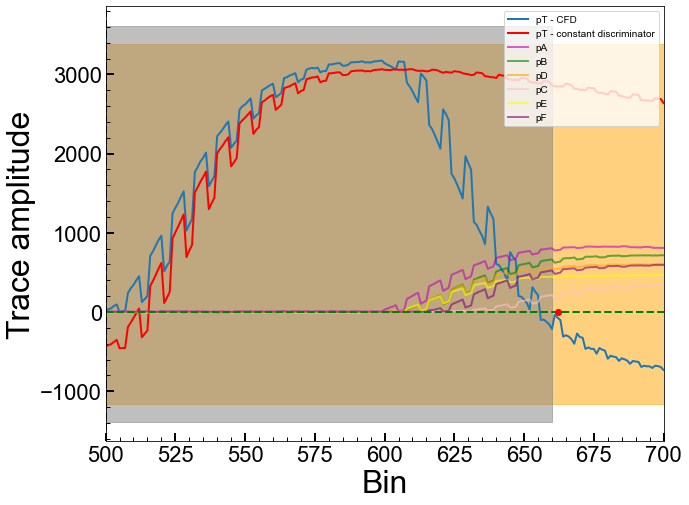

Series Number: 72209162200
Event Number: 6480454
Energy: 42.55089627324 keV


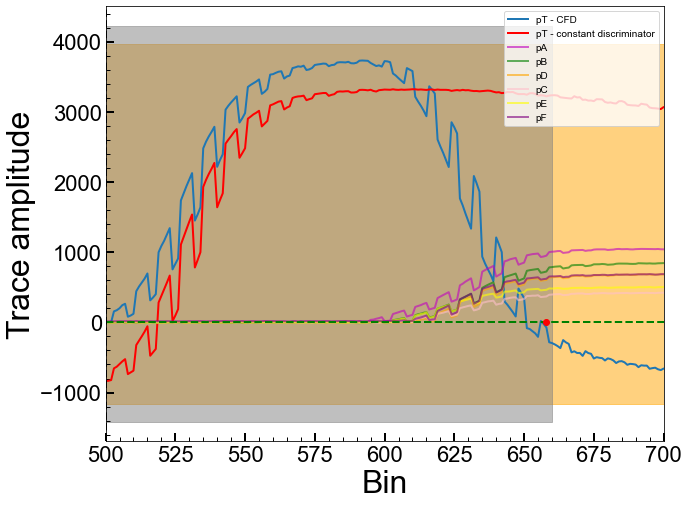

Series Number: 72209162200
Event Number: 6530178
Energy: 12.91075301433 keV


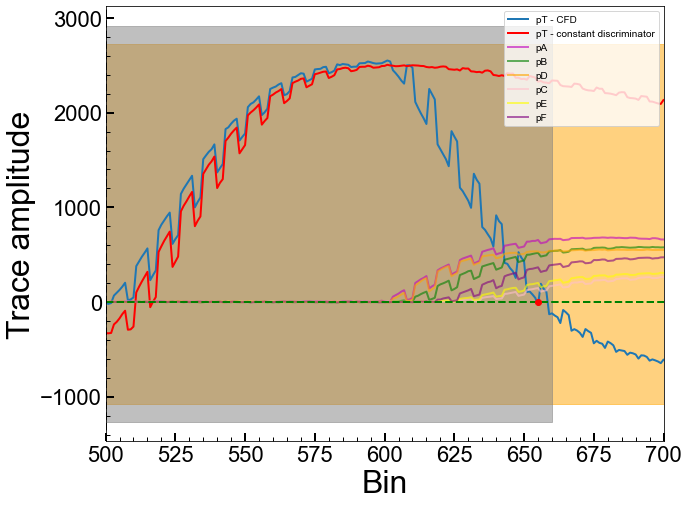

Series Number: 72209162200
Event Number: 6670003
Energy: 10.26453129516 keV


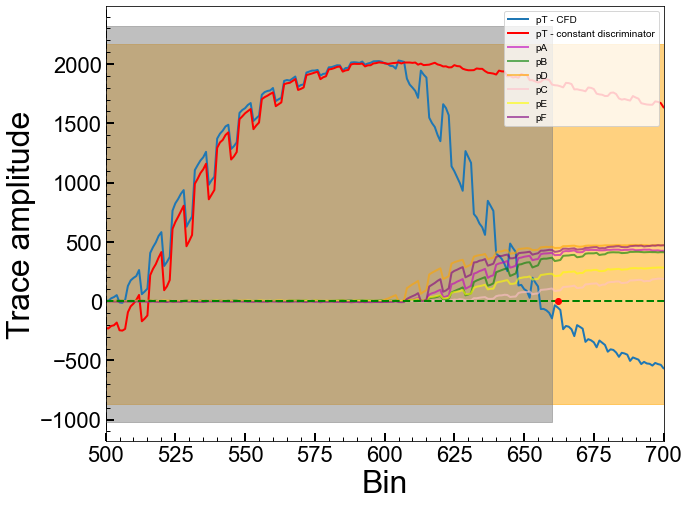

Series Number: 72209162200
Event Number: 6830112
Energy: 23.21451278727 keV


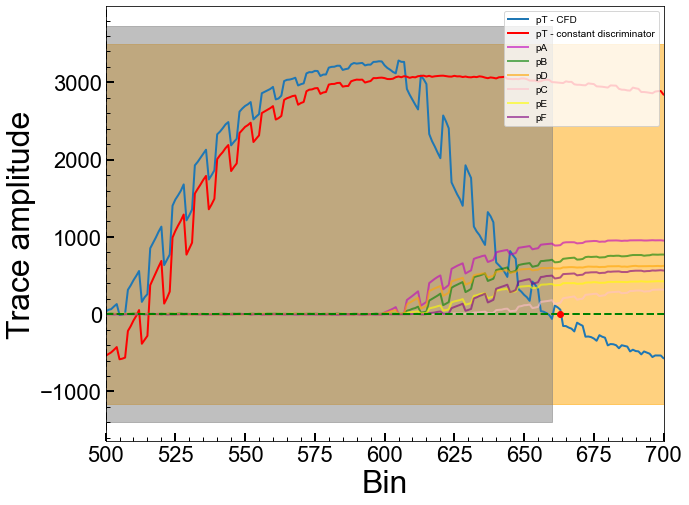

Series Number: 72209162200
Event Number: 7170190
Energy: 14.9688401648 keV


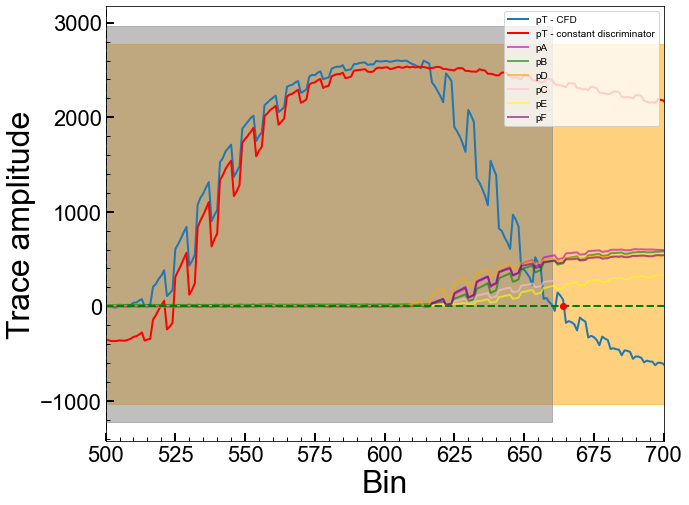

Series Number: 72209162200
Event Number: 7330541
Energy: 18.45897791498 keV


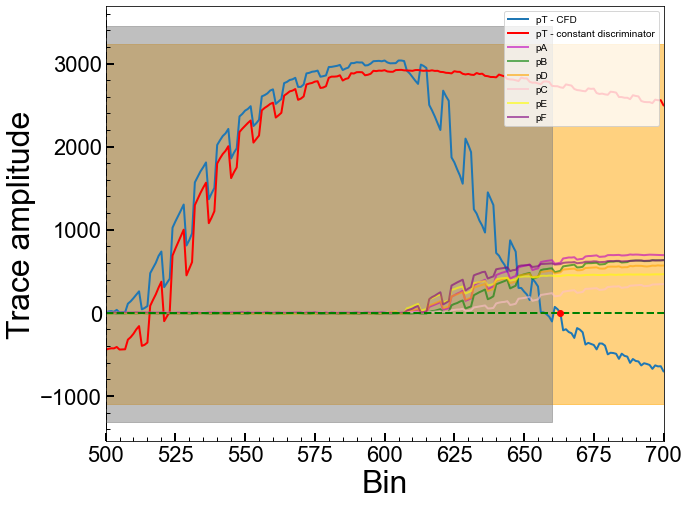

Series Number: 72209172155
Event Number: 1820924
Energy: 18.27373501658 keV


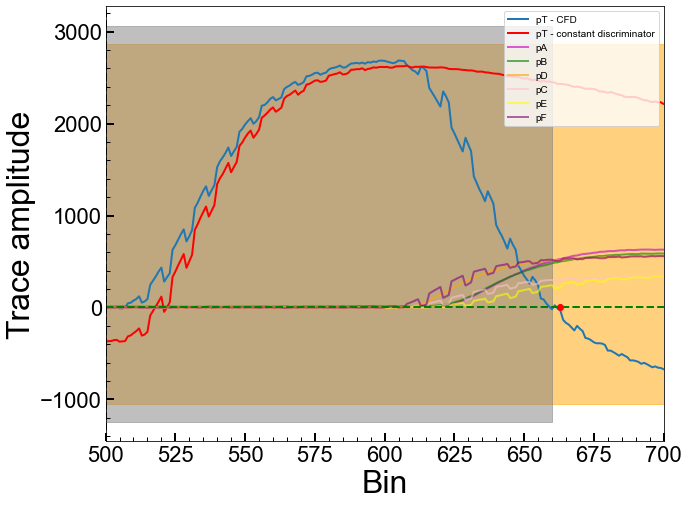

In [11]:
loops = 0
time_reg = []
time_reg_cut=[]
energies = []
energies_cut=[]
bad=[]
goodevs=[]
plot = True
noisyBois=[4000494, 5960312, 6480454, 4960169, 5830100, 3560843, 3680615, 4160243, 5650437, 5790661, 5810300, 5830100, 5850078, 6300112, 6830112, 7330541, 1820924,  5290181, 5180413, 5290181, 6100761, 6530178, 6670003, 7170190]

print(len(noisyBois))
for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue
        #print(ser)

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCFD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        #print(ser)
        pTCD=getPTPulse(exampleObj,ser,ev)+3000
        baseline1 = getBaseline(pTCD)
        xB1 = np.linspace(0, 4095, 4096)
        yB1 = baseline(xB1)
        
        pA,pB,pC,pD,pE,pF=getPABDPulseCD(exampleObj,ser,ev)
        pA = tuple(val + 3000 for val in pA)
        pB = tuple(val + 3000 for val in pB)
        pD = tuple(val + 3000 for val in pD)
        pC = tuple(val + 3000 for val in pC)
        pE = tuple(val + 3000 for val in pE)
        pD = tuple(val + 3000 for val in pD)
        baselinePA = getBaseline(pA)
        baselinePB = getBaseline(pB)
        baselinePC = getBaseline(pC)
        baselinePD = getBaseline(pD)
        baselinePE = getBaseline(pE)
        baselinePF = getBaseline(pF)
        yBpA = baselinePA(xB1)
        yBpB = baselinePB(xB1)
        yBpC = baselinePC(xB1)
        yBpD = baselinePD(xB1)
        yBpE = baselinePE(xB1)
        yBpF = baselinePF(xB1)

        
        #baseline discriminator - weird diagonal pulses
        bshifted_pT = np.subtract(pT,yB)
        bshifted_pTCD=np.subtract(pTCD,yB1)
        bshifted_pA = np.subtract(pA,yBpA)
        bshifted_pB = np.subtract(pB,yBpB)
        bshifted_pC = np.subtract(pC,yBpC)
        bshifted_pD = np.subtract(pD,yBpD)
        bshifted_pE = np.subtract(pE,yBpE)
        bshifted_pF = np.subtract(pF,yBpF)




        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 0, atol=75.0) #changed from 250
            
            #t = 0
            #for i in range(0,750):
            #    if (crosses[i] == True):
            #        time_reg.append(i)
            #        #print("Crosses at bin: " + str(i))
            #        energies.append(energy)
                    #t += 1
            #        break
                    
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 1000):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                time_reg.append(best_cross)
                energies.append(energy)
                if getBadBL(exampleObj,ser,ev):
                    time_reg_cut.append(best_cross)
                    energies_cut.append(energy)
                
                #t += 1
                plot_cross = True
                
                    
            if (plot==True) and (ev in noisyBois):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT - CFD")
                ax1.plot(bshifted_pTCD, color="red", label="pT - constant discriminator")
                ax1.plot(bshifted_pA,color='m', alpha=0.6, label="pA")
                ax1.plot(bshifted_pB,color='green',alpha=0.6,  label='pB')
                ax1.plot(bshifted_pD, color='orange',alpha=0.6,  label='pD')
                ax1.plot(bshifted_pC,color='pink',alpha=0.6, label="pC")
                ax1.plot(bshifted_pE,color='yellow', alpha=0.6, label='pE')
                ax1.plot(bshifted_pF, color='purple', alpha=0.6, label='pF')
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':10})
                ax1.set_xlim(500,700)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')
                    
                    fixedWidth=160
                    fixedWidth1=400
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth1, color='orange', alpha=0.5)
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth, color='gray', alpha=0.5)

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1